# Propensity to fund mortgages: ensemble models

Author: Yoann Pradat

Competition hosted on crowdanalytix.com. It aims at predicting whether a mortgage will be funded or not based on applicant's data. It is therefore a binary classification problem.

In [2]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpy as np
import pandas as pd

import os
import sys

import itertools
import time
import warnings

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from imblearn.over_sampling import SMOTENC

In [136]:
class Ignore(BaseEstimator, TransformerMixin):
    def __init__(self, cols_ignore):
        self.cols_ignore=cols_ignore
    def fit(self, X, y):
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_ignore:
            del Xc[x]
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class Preprocesser(BaseEstimator, TransformerMixin):
    def __init__(self, cols_num, eps=1e-1):
        self.cols_num=cols_num
        self.esp = eps
    def fit(self, X, y):
        self.tds_upper = X.tds.quantile(0.99)
        self.gds_upper = X.gds.quantile(0.99)
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        # Indicator of extreme values
        Xc.loc[:, 'tds_le_0'] = np.where(Xc.tds <= 0, 1, 0)
        Xc.loc[:, 'ltv_gt_80'] = np.where(Xc.ltv > 80, 1, 0)
        # Clip too extreme values of tds and tmgds
        Xc.loc[:, 'tds'] = Xc.tds.clip(lower=0, upper=self.tds_upper)
        Xc.loc[:, 'gds'] = Xc.gds.clip(lower=0, upper=self.gds_upper)
        # Log transform
        eps = 1e-1
        for x in self.cols_num:
            Xc.loc[:, x] = np.log10(Xc[x] + eps)
        # As gds and tds are very correlated (0.99) we will only keep tds and add feature tds - gds
        Xc.loc[:, 'tmgds'] = Xc.loc[:, 'tds'] - Xc.loc[:, 'gds']
        del Xc['gds']
        return Xc  

class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, center=True, norm_ord=2):
        self.center=center
        self.norm_ord=norm_ord
    def fit(self, X, y):
        n, _ = X.shape
        self.centers = {}
        self.norms = {}
        for x in X:
            if X[x].dtype=='object' or set(X[x].unique()).issubset(set([0,1])):
                pass
            elif self.center:
                center = np.mean(X[x])
                norm = np.linalg.norm(X[x]-center)
                self.centers[x] = center
                self.norms[x] = norm/np.sqrt(n)
            else:
                norm = np.linalg.norm(X[x]-center, ord=norm_ord)
                self.norms[x] = norm/np.sqrt(n)
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in Xc:
            if Xc[x].dtype=='object' or set(X[x].unique()).issubset(set([0,1])):
                pass
            elif self.center:
                Xc.loc[:, x] = (Xc[x]-self.centers[x])/self.norms[x]
            else:
                Xc.loc[:, x] = Xc[x]/self.norms[x]
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

class HotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols_onehot, categories, other_lim=0.005):
        self.cols_onehot = cols_onehot
        self.categories = categories
        self.other_lim = other_lim
    def fit(self, X, y):
        n, _ = X.shape
        self.category_other = {}
        for x, category in zip(self.cols_onehot, self.categories):
            category_other = []
            x_counts = X[x].value_counts()
            for cat in category:
                if cat not in x_counts.index:
                    category_other.append(cat)
                elif x_counts[cat]/n < self.other_lim:
                    category_other.append(cat)
            self.category_other[x] = category_other
        Xc = pd.DataFrame.copy(X)
        for i, x in enumerate(self.cols_onehot):
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
        self.categories = [Xc[x].unique() for x in self.cols_onehot]
        self.onehotenc = OneHotEncoder(categories=self.categories)
        self.onehotenc.fit(Xc[self.cols_onehot])
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_onehot:
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
        Xdummy = self.onehotenc.transform(Xc[self.cols_onehot])
        Xdummy = Xdummy.toarray()
        cols_Xdummy = ['']*Xdummy.shape[1]
        offset = 0
        for x, category in zip(self.cols_onehot, self.categories):
            for i, cat in enumerate(category):
                cols_Xdummy[offset + i] = '%s_%s' % (x, str(cat))
            offset += len(category)
            del Xc[x]
        Xdummy = pd.DataFrame(Xdummy, columns=cols_Xdummy).astype(int)
        Xdummy.index = index=Xc.index
        for x, category in zip(self.cols_onehot, self.categories):
            if 'other' in category:
                del Xdummy['%s_%s' % (x, 'other')]
            else:
                del Xdummy['%s_%s' % (x, str(category[0]))]
        Xc = pd.concat((Xc, Xdummy), axis=1)
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class LabEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols_cat, categories, other_lim=0.005):
        self.cols_cat = cols_cat
        self.categories = categories
        self.other_lim = other_lim
    def fit(self, X, y):
        n, _ = X.shape
        self.encoders = {}
        self.category_other = {}
        for x, category in zip(self.cols_cat, self.categories):
            category_other = []
            x_counts = X[x].value_counts()
            for cat in category:
                if cat not in x_counts.index:
                    category_other.append(cat)
                elif x_counts[cat]/n < self.other_lim:
                    category_other.append(cat)
            self.category_other[x] = category_other
            
        Xc = pd.DataFrame.copy(X)
        self.categories = []
        for i, x in enumerate(self.cols_cat):
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
            Xc.loc[:, x] = Xc.loc[:, x].astype(str)
            self.categories.append(Xc[x].unique())
            encoder = LabelEncoder()
            encoder.fit(Xc[x])
            self.encoders[x] = encoder
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_cat:
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
            Xc.loc[:, x] = Xc.loc[:, x].astype(str)
            Xc.loc[:, x] = self.encoders[x].transform(Xc[x])
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

def plot_learning_curve(param_grid, best_params, cv_results, params_logscale=[]):
    best_params_plot = {}
    for param_n, param_v in param_grid.items():
        if len(param_v) > 1:
            best_params_plot[param_n] = best_params[param_n]           
    ncols = 2
    nrows = np.int(np.ceil(len(best_params_plot)/ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4))
    ax = ax.flatten()
    
    for i, (param_n, param_v) in enumerate(best_params_plot.items()):
        best_idx = []
        for idx, params  in enumerate(cv_results['params']):
            if all([params[x] == best_params[x] for x in best_params.keys() if x!=param_n]):
                best_idx.append(idx)
                
        param_values = np.array([cv_results['params'][idx][param_n] for idx in best_idx])
        train_scores_mean = np.array([cv_results['mean_train_score'][idx] for idx in best_idx])
        train_scores_std = np.array([cv_results['std_train_score'][idx] for idx in best_idx])
        test_scores_mean = np.array([cv_results['mean_test_score'][idx] for idx in best_idx])
        test_scores_std = np.array([cv_results['std_test_score'][idx] for idx in best_idx])
        
        ax[i].grid()
        ax[i].fill_between(param_values, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        ax[i].fill_between(param_values, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax[i].plot(param_values, train_scores_mean, 'o-', color="r", label="Training score")
        ax[i].plot(param_values, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax[i].set_title('Learning curve for %s' % param_n, fontsize=18, fontweight='bold')
        if param_n in params_logscale:
            ax[i].set_xscale('log')
        ax[i].legend(loc="best")
    if i < 2*nrows-1:
        ax[-1].axis('off')
    plt.show(fig)
    
# Function useful to compare coefficients
# Default parameters are for comparison across the 5 splits

def plot_compare_coeffs(list_coeffs, title, list_positions = [-3.5, -1.5, 0, 1.5, 3.5], 
                        list_colors = ['red', 'limegreen', 'black', 'royalblue', 'gold'],
                        list_ecolors = ['lightsalmon', 'palegreen', 'lightgray', 'lightskyblue', 'palegoldenrod'], 
                        list_els=['-', '-', '-', '-', '-'], 
                        list_colors_labels = ['red', 'limegreen', 'black', 'royalblue', 'gold'],
                        list_labels = ['split 1', 'split 2', 'split 3', 'split 4', 'split 5'], 
                        list_lgd_ls=None, 
                        list_lgd_ls_labels=None, 
                        list_format=['o', 'o', 'o', 'o', 'o']): 
    
    n_coeffs = list_coeffs[0].shape[0]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))

    for i, col, ecol, coeffs, els, fmt in zip(list_positions, list_colors, list_ecolors, list_coeffs, list_els, list_format):
        eb = ax.errorbar(x=np.arange(n_coeffs) + i / 10, 
                         y=coeffs.values, 
                         yerr=[coeffs.values, np.zeros(n_coeffs)],
                        fmt=fmt, color=col, ecolor=ecol, elinewidth=3, capsize=0)
        eb[-1][0].set_linestyle(els)

    ax.set_xticks(np.arange(-1, n_coeffs + 1))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i in range(1, len(labels) - 1):
        labels[i] = coeffs.index[i - 1][0:20]
    ax.set_xticklabels(labels)

    if n_coeffs >= 15:
        for tick in ax.get_xticklabels():
            tick.set_rotation(75)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('coef', fontweight='bold', fontsize=20)
    ax.set_title("Coeffs of %s" % title, fontweight='bold', size=25)

    ax.xaxis.grid(which='major', linewidth=0.2)
    ax.yaxis.grid(which='major', linewidth=0.35, linestyle="--")
    ax.axhline(0, color='gray', linewidth=0.5)

    custom_lines = []
    for c in list_colors_labels:
        custom_lines.append(Line2D([0], [0], color=c, ls="-", lw=4))

    if list_lgd_ls_labels is None:
        ax.legend(custom_lines, list_labels)
    else:
        custom_lines.append(Line2D([0], [0], color='gray', ls='-', lw=0))
        for ls in list_lgd_ls:
            custom_lines.append(Line2D([0], [0], color='gray', ls=ls, lw=2))
        ax.legend(custom_lines, list_labels+['']+list_lgd_ls_labels)

    if n_coeffs >= 15:
        fig.subplots_adjust(left=0.05, bottom=0.25, right=0.95, top=0.90, wspace=0.4)
    else:
        fig.subplots_adjust(left=0.05, bottom=0.10, right=0.95, top=0.90)

    plt.show(fig)

def f1_macro(y_pred, y_true):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    precisions = {}
    recalls = {}
    f1s = {}
    for cl in np.unique(y_true):
        if sum(y_pred==cl)==0:
            precision = 0
        else:
            precision = sum((y_pred==cl) & (y_true==cl))/sum(y_pred==cl)
        if sum(y_true==cl)==0:
            print("Warning! Ill-defined f1-score as no label of the class is in y_true")
            recall = 0
        else:
            recall = sum((y_pred==cl) & (y_true==cl))/sum(y_true==cl)
        
        if recall+precision == 0:
            f1 = 0
        else:
            f1 = 2*recall*precision/(recall + precision)
        precisions[cl] = precision
        recalls[cl] = recall
        f1s[cl] = f1
    return precisions, recalls, f1s

class MortgageData(object):
    def __init__(self, train_file="../data/CAX_MortgageModeling_Train.csv", test_file="../data/CAX_MortgageModeling_Test.csv", 
                 encoder="Hot", n_splits=5, random_state=0, other_lim=0.005):
        self.n_splits = n_splits
        self.random_state = random_state
        self.other_lim = other_lim
        self.resampled = False
        # Load data
        data_train = pd.read_csv(train_file) 
        data_test = pd.read_csv(test_file, usecols=lambda x: x not in ["RESULT"]) 
        
        # Lower case column names
        data_train.columns = list(map(str.lower, data_train.columns))
        data_test.columns = list(map(str.lower, data_test.columns))
        
        # Categorical features
        cols_cat = ['amortization', 'mortgage purpose', 'payment frequency', 'property type', 'term', 'age range',
                   'gender', 'income type', 'naics code']
        data_train[cols_cat] = data_train[cols_cat].astype('object')
        data_test[cols_cat] = data_test[cols_cat].astype('object')

        # Compartimentalize features
        self.X_train = data_train.iloc[:, :-1]  
        self.y_train = data_train.iloc[:, -1].map({"NOT FUNDED": 0, "FUNDED":1})
        self.X_test = data_test
        cols_ignore = ['unique_id', 'mortgage number', 'fsa']
        cols_cat = [x for x in self.X_train if self.X_train[x].dtype==object and x not in cols_ignore]
        cols_num = [x for x in self.X_train.columns if x not in cols_cat and x not in cols_ignore]

        # Make sure all categories of every categorical feature is here
        X_all = pd.concat((self.X_train, self.X_test), axis=0)
        categories = [X_all[x].unique() for x in cols_cat]
        del X_all

        if encoder=="Lab":
            self.tpipe = Pipeline([('ignore', Ignore(cols_ignore=cols_ignore)),
                                   ('preprocesser', Preprocesser(cols_num=cols_num)),
                                   ('scaler', Scaler()),
                                   ('encoder', LabEncoder(categories=categories,cols_cat=cols_cat,other_lim=other_lim))])
        elif encoder=="Hot":
            self.tpipe = Pipeline([('ignore', Ignore(cols_ignore=cols_ignore)),
                                   ('preprocesser', Preprocesser(cols_num=cols_num)),
                                   ('scaler', Scaler()),
                                   ('encoder', HotEncoder(categories=categories,cols_onehot=cols_cat,other_lim=other_lim))])
        else:
            raise ValueError("Please choose between 'Hot' and 'Lab' for encoding of categorical variables.")
        
        # Transform the data
        self.X_ttrain = self.tpipe.fit_transform(self.X_train, self.y_train)
        self.X_ttest = self.tpipe.transform(self.X_test)
        self.n_input = self.X_ttrain.shape[1]
            
        # Resample for balancing data. Used only if prescribed
        categorical_features = [x for x in self.X_ttrain.columns if any([s in x for s in cols_cat])]
        categorical_features = [self.X_ttrain.columns.get_loc(x) for x in categorical_features]
        self.sm = SMOTENC(categorical_features=categorical_features, 
                          sampling_strategy='auto',
                          random_state=random_state,
                          k_neighbors=5,
                          n_jobs=1)
        
        self.categorical_features = categorical_features
        self.strat_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.splits = []
        for idx_train, idx_test in self.strat_cv.split(self.X_ttrain, self.y_train):
            self.splits.append((idx_train, idx_test))

    def resample(self, index=None):
        if index is None:
            self.X_ttrain, self.y_train = self.sm.fit_resample(self.X_ttrain, self.y_train)
        else:
            # Split before resampling
            idx_train, idx_test = self.splits[index]
            self.X_tttrain, self.y_ttrain = self.X_ttrain.iloc[idx_train], self.y_train.iloc[idx_train]
            self.X_tttrain, self.y_ttrain = self.sm.fit_resample(self.X_tttrain, self.y_ttrain)
            self.X_tttrain = pd.DataFrame(self.X_tttrain, columns=self.X_ttrain.columns)
            self.y_ttrain = pd.Series(self.y_ttrain)
            self.X_tttest, self.y_ttest = self.X_ttrain.iloc[idx_test], self.y_train.iloc[idx_test]
        self.resampled = True
        return self

    def get_train(self, index=None):
        if index is None:
            return self.X_ttrain, self.y_train
        else:
            if self.resampled:
                return self.X_tttrain, self.X_tttest, self.y_ttrain, self.y_ttest
            else:
                idx_train, idx_test = self.splits[index]
                self.X_tttrain, self.y_ttrain = self.X_ttrain.iloc[idx_train], self.y_train.iloc[idx_train]
                self.X_tttest, self.y_ttest = self.X_ttrain.iloc[idx_test], self.y_train.iloc[idx_test]
                return self.X_tttrain, self.X_tttest, self.y_ttrain, self.y_ttest

    def get_test(self):
        return self.X_ttest

def f1_macro_score(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)[:, 1]
    y_pred = np.where(y_pred_proba > 0.75, 1, 0)
    return f1_score(y_pred, y_true, average='macro')
    
def f1_macro_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.where(y_pred > 0.7, 1, 0)
    return 'f1_macro', f1_score(y_true, y_pred, average='macro'), True
    
def softmax(X):
    return np.exp(X)/np.sum(np.exp(X), axis=1).reshape(-1, 1)

In [360]:
def f1_macro_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.where(y_pred > 0.75, 1, 0)
    return 'f1_macro', f1_score(y_true, y_pred, average='macro'), True

class GBMGridSearch(BaseEstimator, TransformerMixin):
    def __init__(self, cols_cat, param_grid, scoring, cv, verbose):
        self.cols_cat = cols_cat
        self.param_grid = param_grid
        self.scoring = scoring
        self.cv = cv
        self.verbose = verbose
        
    def fit(self, X, y):
        self.cv_results_= {}
        self.best_params_ = {}
        splits = []
        for idx_train, idx_test in self.cv.split(X, y):
            splits.append((idx_train, idx_test))
        
        n_splits = self.cv.get_n_splits()
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())
        params_combinations = list(itertools.product(*(param_values)))
        n_combinations = len(params_combinations)
        
        for i in range(n_splits):
            self.cv_results_['split%d_train_score'%i] = np.zeros(n_combinations)
            self.cv_results_['split%d_test_score'%i] = np.zeros(n_combinations)
        self.cv_results_['mean_train_score'] = np.zeros(n_combinations)
        self.cv_results_['std_train_score'] = np.zeros(n_combinations)
        self.cv_results_['mean_test_score'] = np.zeros(n_combinations)
        self.cv_results_['std_test_score'] = np.zeros(n_combinations)
        self.cv_results_['params'] = []
        
        st_time = time.time()
        self.best_score_ = 0
        self.best_params_ = {}
        self.best_estimator_ = {}
        
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())
        for j, params in enumerate(params_combinations):
            d_params = {k:v for (k,v) in zip(param_names, params)}
            str_d_params = '; '.join(["%s: %s" % (str(k), str(v)) for k,v in d_params.items()])
            if self.verbose > 0:
                print("[fit %d/%d] %.3g s| params %s"%(j+1, n_combinations, time.time()-st_time, str_d_params))

            scores_train = []
            scores_test = []
            for i, (idx_train, idx_test) in enumerate(splits):
                lgb_train = lgb.Dataset(X.iloc[idx_train], y.iloc[idx_train], feature_name='auto', categorical_feature=self.cols_cat, free_raw_data=False)
                lgb_test = lgb.Dataset(X.iloc[idx_test], y.iloc[idx_test], feature_name='auto', categorical_feature=self.cols_cat, free_raw_data=False)

                gbm = lgb.train(d_params,
                                lgb_train,
                                feval=f1_macro_eval,
                                valid_sets=[lgb_test],               
                                valid_names=['test'],
                                verbose_eval=False)

                _, score_train, _ = self.scoring(gbm.predict(X.loc[idx_train]), lgb_train)
                _, score_test, _ = self.scoring(gbm.predict(X.loc[idx_test]), lgb_test)
                scores_train.append(score_train)
                scores_test.append(score_test)
                self.cv_results_['split%d_train_score'%i][j] = score_train
                self.cv_results_['split%d_test_score'%i][j] = score_test
                if self.verbose > 1:
                    print("[cv %d/%d] | train score %.3g ; test score % .3g" % (i+1, n_splits, score_train, score_test))

            if np.mean(scores_test) > self.best_score_:
                self.best_score_ = np.mean(scores_test)
                self.best_params_ = d_params
                self.best_estimator_ = gbm
                
            self.cv_results_['mean_train_score'][j] = np.mean(scores_train)
            self.cv_results_['std_train_score'][j] = np.std(scores_train)
            self.cv_results_['mean_test_score'][j] = np.mean(scores_test)
            self.cv_results_['std_test_score'][j] = np.std(scores_test)
            self.cv_results_['params'].append(d_params)
        return self

# I. Load the predictions of base learners

In [133]:
random_state = 0
mortgage_data = MortgageData(encoder="Lab")

# To get row ids
X_train = mortgage_data.X_train
X_test = mortgage_data.X_test

# Data used to train base models
X_ttrain, y_train = mortgage_data.get_train()
X_ttest = mortgage_data.get_test()

strat_cv = mortgage_data.strat_cv
splits = mortgage_data.splits

In [81]:
df_btrain = pd.DataFrame({"Index test": X_train.index.values})
df_btest = pd.DataFrame({"Unique_ID": X_test.unique_id.values})
bstrat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

## I.1 MLPNets predictions

In [329]:
model_type = "MLP_1"
model_names = ["MLPNet3", "MLPNet3Drop", "MLPNet4", "MLPNet4Drop", "MLPNet5", "MLPNet5Drop"]
dropout_rates = [0.2, 0.4]
index_splits = [1, 2, 3, 4, 5]

path_pred  = "../predictions/%s" % model_type

for model_name in model_names:
    if "Drop" in model_name:
        for p in dropout_rates:
            model_name_p = model_name + "_" + str(p) + "_"
            col_name = "%s_class_1" % model_name_p
            df_btrain.loc[:, col_name] = -1
            df_btest.loc[:, col_name] = -1
            
            # On splits
            for index_split in index_splits:
                df_pred_split = pd.read_csv(os.path.join(path_pred, "%s_split_%d.csv" % (model_name_p, index_split)))
                pred_proba_split = softmax(df_pred_split[["Output 0", "Output 1"]].values)
                df_pred_split.loc[:, col_name] = pred_proba_split[:, 1]
                df_btrain.loc[df_btrain['Index test'].isin(df_pred_split['Index test']), col_name] = df_pred_split[col_name].values

            # On test data
            df_pred_test = pd.read_csv(os.path.join(path_pred, "%s_test.csv" % (model_name_p)))
            pred_proba_test = softmax(df_pred_test[["Output 0", "Output 1"]].values)
            df_pred_test.loc[:, col_name] = pred_proba_test[:, 1]
            df_btest.loc[df_btest.Unique_ID.isin(df_pred_test.Unique_ID), col_name] = df_pred_test[col_name].values
    else:
        col_name = "%s_class_1" % model_name
        df_btrain.loc[:, col_name] = -1
        df_btest.loc[:, col_name] = -1
            
        # On splits
        for index_split in index_splits:
            df_pred_split = pd.read_csv(os.path.join(path_pred, "%s_split_%d.csv" % (model_name, index_split)))
            pred_proba_split = softmax(df_pred_split[["Output 0", "Output 1"]].values)
            df_pred_split.loc[:, col_name] = pred_proba_split[:, 1]
            df_btrain.loc[df_btrain['Index test'].isin(df_pred_split['Index test']), col_name] = df_pred_split[col_name].values

        # On test data
        df_pred_test = pd.read_csv(os.path.join(path_pred, "%s_test.csv" % (model_name)))
        pred_proba_test = softmax(df_pred_test[["Output 0", "Output 1"]].values)
        df_pred_test.loc[:, col_name] = pred_proba_test[:, 1]
        df_btest.loc[df_btest.Unique_ID.isin(df_pred_test.Unique_ID), col_name] = df_pred_test[col_name].values

In [85]:
df_btrain.iloc[:,1:].corr()

,MLPNet3_class_1,MLPNet3Drop_0.2__class_1,MLPNet3Drop_0.4__class_1,MLPNet4_class_1,MLPNet4Drop_0.2__class_1,MLPNet4Drop_0.4__class_1,MLPNet5_class_1,MLPNet5Drop_0.2__class_1,MLPNet5Drop_0.4__class_1
MLPNet3_class_1,1.000000,0.866761,0.864560,0.836149,0.864013,0.846495,0.840310,0.818325,0.479861
MLPNet3Drop_0.2__class_1,0.866761,1.000000,0.931279,0.866039,0.934457,0.916274,0.865262,0.854211,0.526858
MLPNet3Drop_0.4__class_1,0.864560,0.931279,1.000000,0.831141,0.934712,0.958625,0.839157,0.841712,0.549056
MLPNet4_class_1,0.836149,0.866039,0.831141,1.000000,0.846174,0.816076,0.848204,0.786454,0.466499
MLPNet4Drop_0.2__class_1,0.864013,0.934457,0.934712,0.846174,1.000000,0.925791,0.849886,0.854745,0.531611
MLPNet4Drop_0.4__class_1,0.846495,0.916274,0.958625,0.816076,0.925791,1.000000,0.823767,0.852494,0.549599
MLPNet5_class_1,0.840310,0.865262,0.839157,0.848204,0.849886,0.823767,1.000000,0.789876,0.464504
MLPNet5Drop_0.2__class_1,0.818325,0.854211,0.841712,0.786454,0.854745,0.852494,0.789876,1.000000,0.651588
MLPNet5Drop_0.4__class_1,0.479861,0.526858,0.549056,0.466499,0.531611,0.549599,0.464504,0.651588,1.000000


### Correlation matrix train

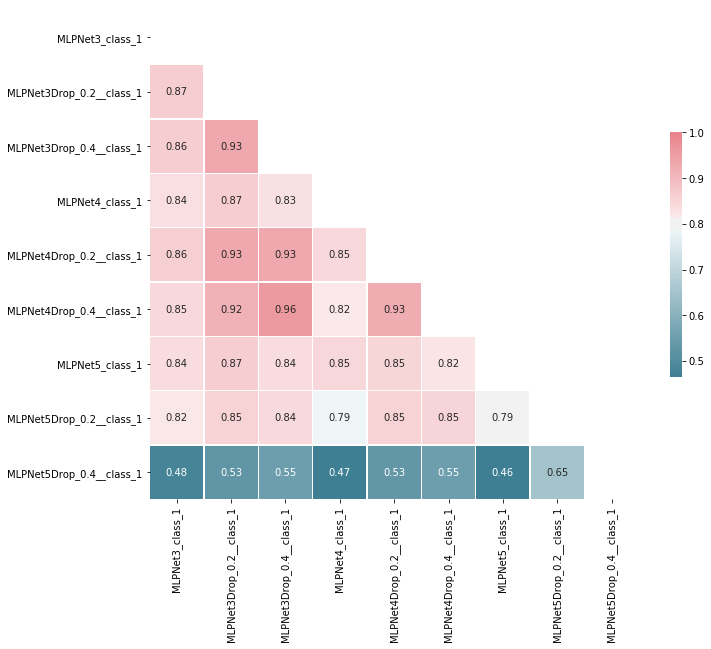

In [114]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = df_btrain.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0.8, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

### Correlation matrix test

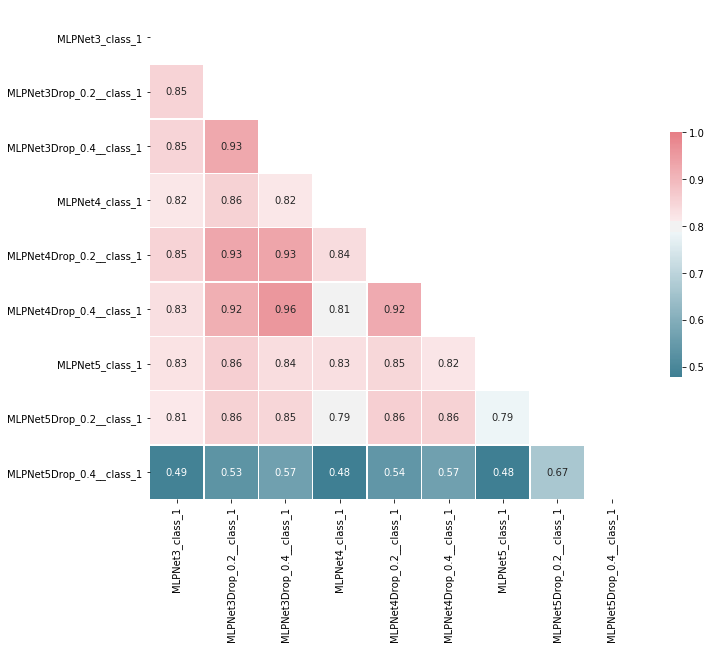

In [110]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = df_btest.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0.8, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

In [209]:
bttrain, bttest, y_bttrain, y_bttest = train_test_split(df_btrain.iloc[:, 1:], y_train, stratify=y_train,
                                                        random_state=random_state, test_size=0.1)

## Ensemble Models on MLP_1

### Logistic regression

In [210]:
%%time
clf = LogisticRegression(solver='liblinear', 
                         fit_intercept=True, 
                         random_state=random_state)

param_grid = {'C':np.logspace(-2, 2, 10), 'penalty':['l1', 'l2']}
grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring=f1_macro_score, 
                    cv=bstrat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

warnings.filterwarnings('ignore')
grid = grid.fit(bttrain, y_bttrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   15.7s finished


CPU times: user 1.14 s, sys: 88.4 ms, total: 1.23 s
Wall time: 16.3 s


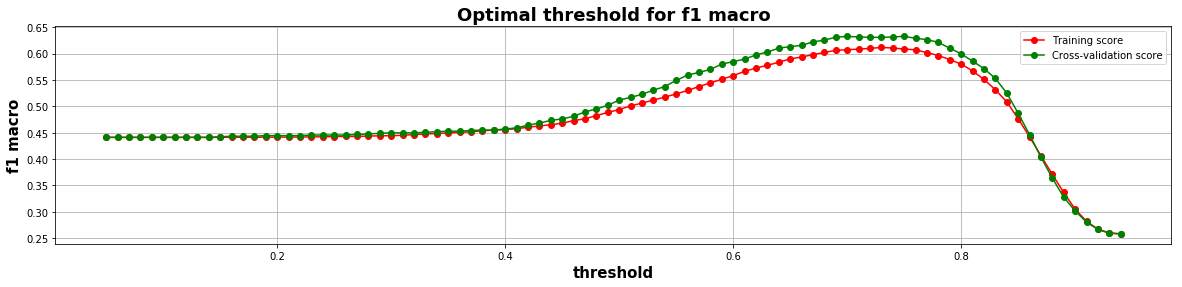

CPU times: user 936 ms, sys: 35.5 ms, total: 971 ms
Wall time: 884 ms


In [211]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = grid.best_estimator_.predict_proba(bttrain)[:, 1]
y_prob_val = grid.best_estimator_.predict_proba(bttest)[:, 1]

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_bttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_bttest, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

Best params {'C': 0.0774263682681127, 'penalty': 'l1'}
Class 0 | precision 0.2788; recall 0.751; f1 0.4067 
Class 1 | precision 0.8786; recall 0.4813; f1 0.6219 


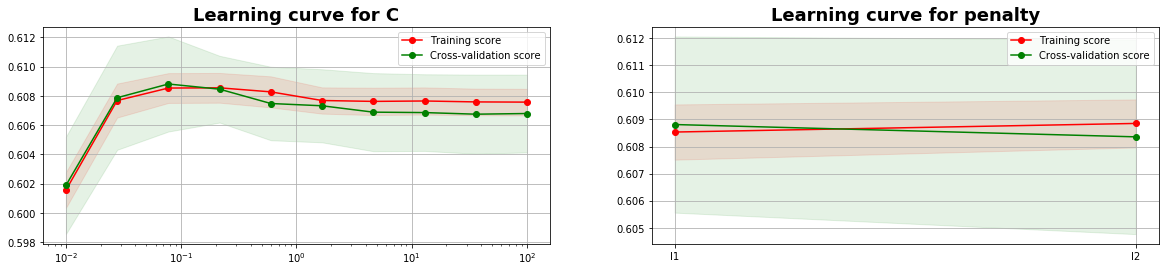

In [212]:
y_pred = np.where(grid.best_estimator_.predict_proba(bttrain)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttrain)
print("="*40)
print("Train")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred = np.where(grid.best_estimator_.predict_proba(bttest)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttest)
print("="*40)
print("Test")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=['C'])

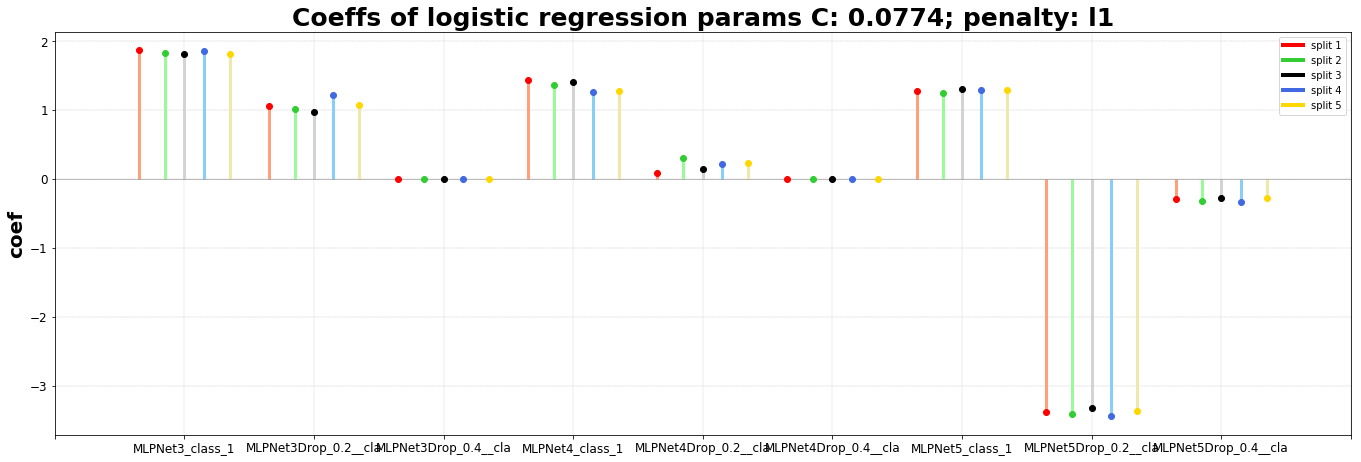

In [213]:
# Compute coefficients on each split with best params
estimator = clone(grid.best_estimator_)
splits = bstrat_cv.split(bttrain, y_bttrain)
list_coeffs = []

for j, (idx_train, idx_test) in enumerate(splits):
    estimator.fit(bttrain.iloc[idx_train], y_bttrain.iloc[idx_train])
    coeffs = pd.DataFrame({'Coef': estimator.coef_.flatten()}, index=bttrain.columns)
    list_coeffs.append(coeffs)

# Plot coefficients 
str_params = []
for k, v in grid.best_params_.items():
    if type(v)==np.int64:
        str_params.append("%s: %d" % (str(k), v))
    elif type(v)==np.float64:
        str_params.append("%s: %.3g" % (str(k), v))
    else:
        str_params.append("%s: %s" % (str(k), str(v)))

title = "logistic regression params %s" % ('; '.join(str_params))

n_coeffs = list_coeffs[0].shape[0]
n_coeffs_fig = 30
n_fig = np.int(np.ceil(n_coeffs/n_coeffs_fig))
for j in range(n_fig):
    sublist_coeffs = [coeffs.iloc[n_coeffs_fig*j:n_coeffs_fig*(j+1)] for coeffs in list_coeffs]
    plot_compare_coeffs(sublist_coeffs, title)

### RandomForest

In [214]:
%%time
clf = RandomForestClassifier(criterion='gini',
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_leaf_nodes=None,
                             bootstrap=True,
                             random_state=random_state,
                             class_weight="balanced")

param_grid = {'n_estimators': [20, 40, 100, 200], 
              'max_depth': [5, 10, 15]}

grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='f1_macro', 
                    cv=strat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

warnings.filterwarnings('ignore')
grid = grid.fit(bttrain, y_bttrain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   52.0s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:  2.4min finished


CPU times: user 13.4 s, sys: 158 ms, total: 13.5 s
Wall time: 2min 37s


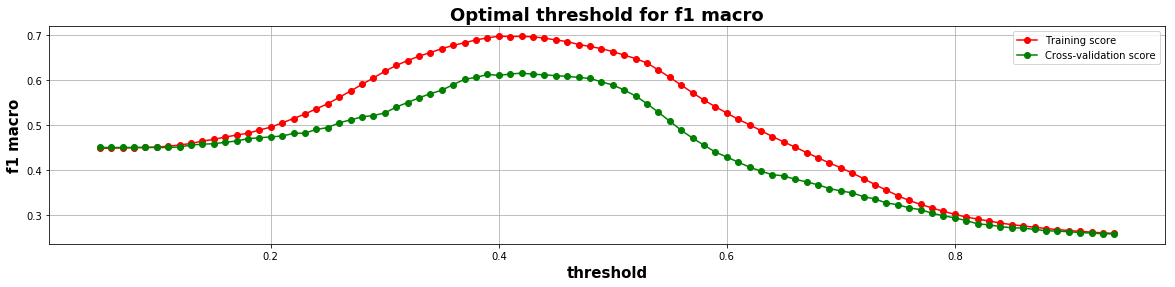

CPU times: user 1.58 s, sys: 25.1 ms, total: 1.6 s
Wall time: 1.63 s


In [215]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = grid.best_estimator_.predict_proba(bttrain)[:, 1]
y_prob_val = grid.best_estimator_.predict_proba(bttest)[:, 1]

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_bttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_bttest, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

Train
Best params {'max_depth': 10, 'n_estimators': 200}
Class 0 | precision 0.4135; recall 0.6814; f1 0.5147 
Class 1 | precision 0.8971; recall 0.7419; f1 0.8122 
Test
Best params {'max_depth': 10, 'n_estimators': 200}
Class 0 | precision 0.3275; recall 0.526; f1 0.4037 
Class 1 | precision 0.849; recall 0.7116; f1 0.7743 


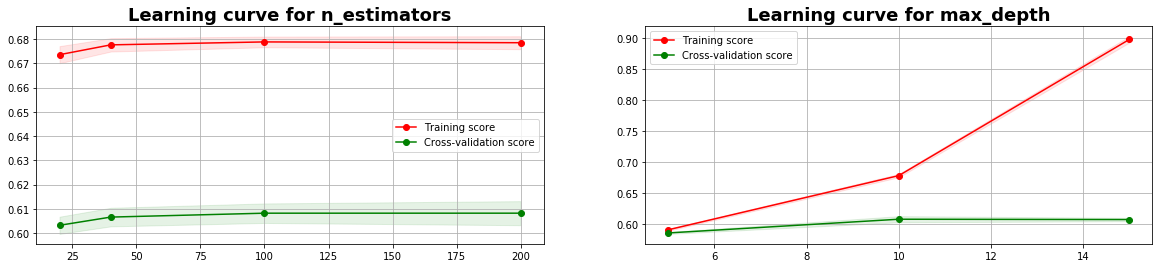

In [216]:
y_pred = np.where(grid.best_estimator_.predict_proba(bttrain)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttrain)
print("="*40)
print("Train")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred = np.where(grid.best_estimator_.predict_proba(bttest)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttest)
print("="*40)
print("Test")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=['C'])

## I.2 RandomForest predictions

In [309]:
df_btrain_rf = pd.DataFrame({"Index test": X_train.index.values})
df_btest_rf = pd.DataFrame({"Unique_ID": X_test.unique_id.values})

In [310]:
model_type = "RandomForest_1"
list_criterion = ['gini', 'entropy']
list_max_features = ['sqrt', 'None']
list_max_depth = [10, 15, 20]
index_splits = [1, 2, 3, 4, 5]

path_pred  = "../predictions/%s" % model_type

for criterion in list_criterion:
    for max_features in list_max_features:
        for max_depth in list_max_depth:
            model_name = "rf_%s_%s_%s" % (criterion, max_features, max_depth)
            col_name = "%s_class_1" % model_name
            
            if not os.path.exists(os.path.join(path_pred, "%s_split_%d.csv" % (model_name, index_split))):
                pass
            else:
                df_btrain_rf.loc[:, col_name] = -1
                df_btest_rf.loc[:, col_name] = -1

                # On splits
                for index_split in index_splits:
                    df_pred_split = pd.read_csv(os.path.join(path_pred, "%s_split_%d.csv" % (model_name, index_split)))
                    df_pred_split.loc[:, col_name] = df_pred_split['Proba class 1']
                    df_btrain_rf.loc[df_btrain_rf['Index test'].isin(df_pred_split['Index test']), col_name] = df_pred_split[col_name].values

                # On test data
                df_pred_test = pd.read_csv(os.path.join(path_pred, "%s_test.csv" % (model_name)))
                df_pred_test.loc[:, col_name] = df_pred_test['Proba class 1']
                df_btest_rf.loc[df_btest_rf.Unique_ID.isin(df_pred_test.Unique_ID), col_name] = df_pred_test[col_name].values

### Correlation matrix train

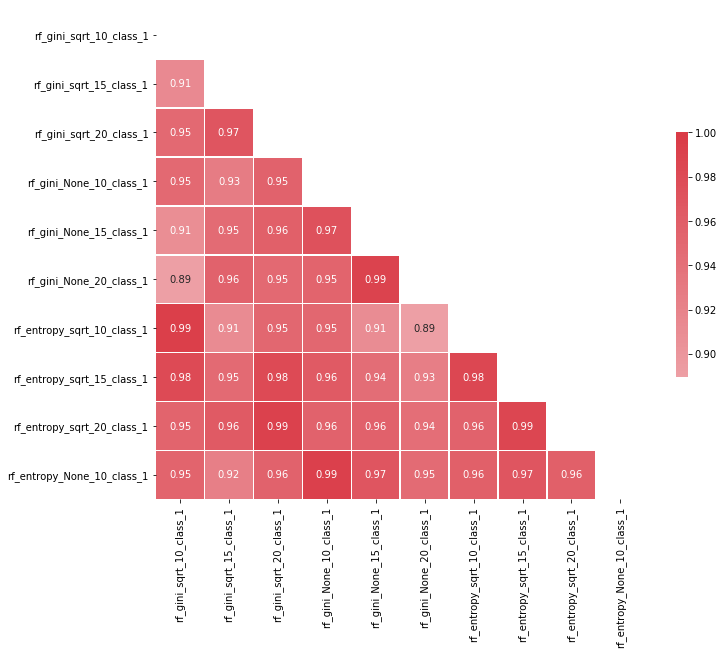

In [219]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = df_btrain_rf.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0.8, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

In [220]:
bttrain_rf, bttest_rf, y_bttrain, y_bttest = train_test_split(df_btrain_rf.iloc[:, 1:], y_train, stratify=y_train,
                                                              random_state=random_state, test_size=0.1)

## Ensemble Models on RandomForest_1

### Mean proba

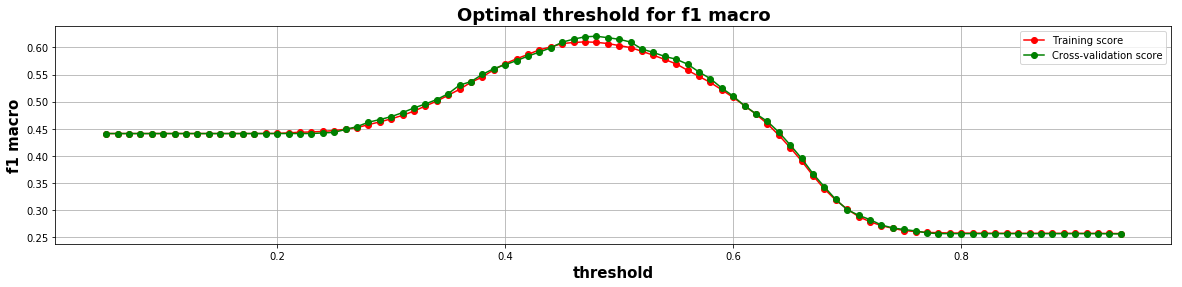

CPU times: user 846 ms, sys: 21.2 ms, total: 867 ms
Wall time: 893 ms


In [239]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = bttrain_rf.mean(axis=1)
y_prob_val = bttest_rf.mean(axis=1)

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_bttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_bttest, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

In [240]:
y_pred = np.where(bttrain_rf.mean(axis=1) > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttrain)
print("="*40)
print("Train")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred = np.where(bttest_rf.mean(axis=1) > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttest)
print("="*40)
print("Test")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

Train
Best params {'C': 0.1, 'penalty': 'l1'}
Class 0 | precision 0.3669; recall 0.438; f1 0.3993 
Class 1 | precision 0.8417; recall 0.7982; f1 0.8194 
Test
Best params {'C': 0.1, 'penalty': 'l1'}
Class 0 | precision 0.3793; recall 0.4719; f1 0.4206 
Class 1 | precision 0.8492; recall 0.7938; f1 0.8205 


### Logistic regression

In [242]:
%%time
clf = LogisticRegression(solver='liblinear', 
                         fit_intercept=True, 
                         random_state=random_state)

param_grid = {'C':np.logspace(-2, 2, 10), 'penalty':['l1', 'l2']}
grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring=f1_macro_score, 
                    cv=bstrat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

warnings.filterwarnings('ignore')
grid = grid.fit(bttrain_rf, y_bttrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    9.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.2min finished


CPU times: user 944 ms, sys: 150 ms, total: 1.09 s
Wall time: 1min 10s


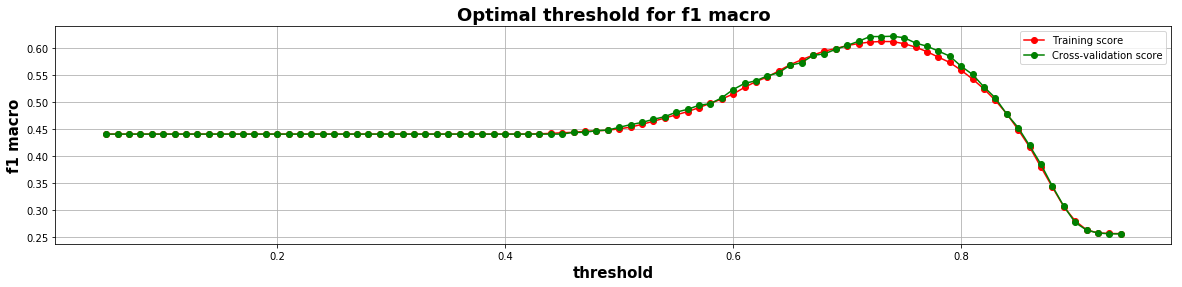

CPU times: user 1.25 s, sys: 271 ms, total: 1.52 s
Wall time: 1.47 s


In [246]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = grid.best_estimator_.predict_proba(bttrain_rf)[:, 1]
y_prob_val = grid.best_estimator_.predict_proba(bttest_rf)[:, 1]

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_bttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_bttest, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

Train
Best params {'C': 0.01, 'penalty': 'l1'}
Class 0 | precision 0.367; recall 0.4639; f1 0.4098 
Class 1 | precision 0.846; recall 0.7863; f1 0.8151 
Test
Best params {'C': 0.01, 'penalty': 'l1'}
Class 0 | precision 0.3798; recall 0.4844; f1 0.4258 
Class 1 | precision 0.8514; recall 0.7888; f1 0.8189 


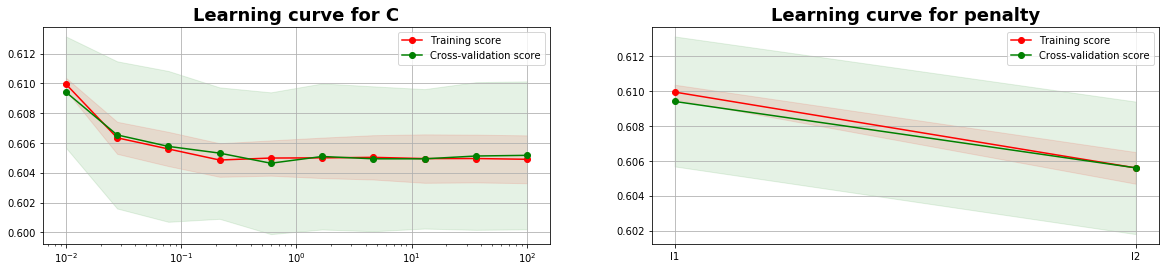

In [247]:
y_pred = np.where(grid.best_estimator_.predict_proba(bttrain_rf)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttrain)
print("="*40)
print("Train")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred = np.where(grid.best_estimator_.predict_proba(bttest_rf)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttest)
print("="*40)
print("Test")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=['C'])

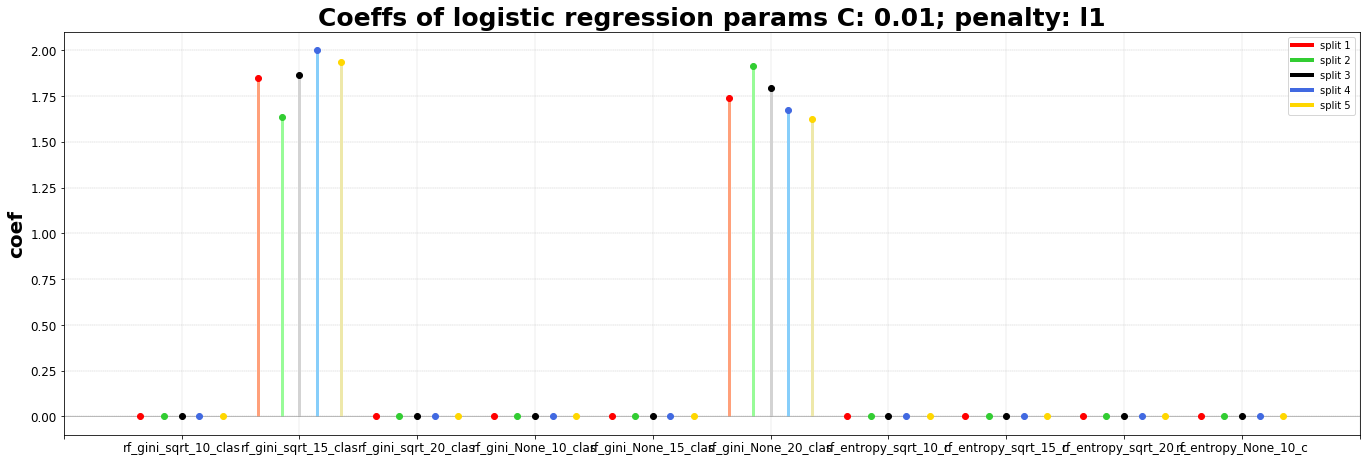

In [248]:
# Compute coefficients on each split with best params
estimator = clone(grid.best_estimator_)
splits = bstrat_cv.split(bttrain_rf, y_bttrain)
list_coeffs = []

for j, (idx_train, idx_test) in enumerate(splits):
    estimator.fit(bttrain_rf.iloc[idx_train], y_bttrain.iloc[idx_train])
    coeffs = pd.DataFrame({'Coef': estimator.coef_.flatten()}, index=bttrain_rf.columns)
    list_coeffs.append(coeffs)

# Plot coefficients 
str_params = []
for k, v in grid.best_params_.items():
    if type(v)==np.int64:
        str_params.append("%s: %d" % (str(k), v))
    elif type(v)==np.float64:
        str_params.append("%s: %.3g" % (str(k), v))
    else:
        str_params.append("%s: %s" % (str(k), str(v)))

title = "logistic regression params %s" % ('; '.join(str_params))

n_coeffs = list_coeffs[0].shape[0]
n_coeffs_fig = 30
n_fig = np.int(np.ceil(n_coeffs/n_coeffs_fig))
for j in range(n_fig):
    sublist_coeffs = [coeffs.iloc[n_coeffs_fig*j:n_coeffs_fig*(j+1)] for coeffs in list_coeffs]
    plot_compare_coeffs(sublist_coeffs, title)

### RandomForest

In [249]:
%%time
clf = RandomForestClassifier(criterion='gini',
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_leaf_nodes=None,
                             bootstrap=True,
                             random_state=random_state,
                             class_weight="balanced")

param_grid = {'n_estimators': [20, 40, 100, 200], 
              'max_depth': [5, 10, 15]}

grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='f1_macro', 
                    cv=bstrat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

warnings.filterwarnings('ignore')
grid = grid.fit(bttrain_rf, y_bttrain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:  3.1min finished


CPU times: user 10.7 s, sys: 178 ms, total: 10.9 s
Wall time: 3min 14s


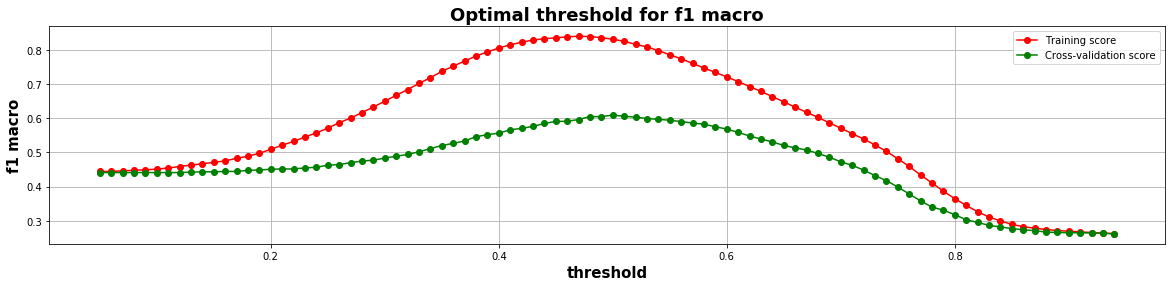

CPU times: user 1.4 s, sys: 43.7 ms, total: 1.44 s
Wall time: 1.48 s


In [250]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = grid.best_estimator_.predict_proba(bttrain_rf)[:, 1]
y_prob_val = grid.best_estimator_.predict_proba(bttest_rf)[:, 1]

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_bttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_bttest, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

Train
Best params {'max_depth': 15, 'n_estimators': 100}
Class 0 | precision 0.6765; recall 0.8197; f1 0.7412 
Class 1 | precision 0.949; recall 0.8953; f1 0.9214 
Test
Best params {'max_depth': 15, 'n_estimators': 100}
Class 0 | precision 0.3681; recall 0.4324; f1 0.3977 
Class 1 | precision 0.841; recall 0.8018; f1 0.821 


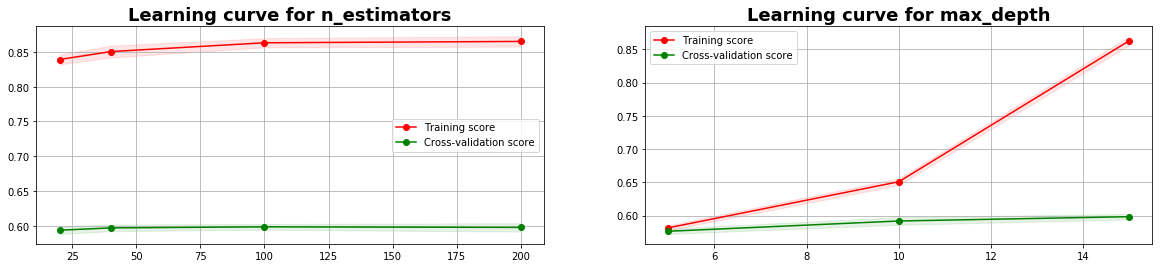

In [251]:
y_pred = np.where(grid.best_estimator_.predict_proba(bttrain_rf)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttrain)
print("="*40)
print("Train")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred = np.where(grid.best_estimator_.predict_proba(bttest_rf)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttest)
print("="*40)
print("Test")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=['C'])

## I.3 LGBM predictions

In [312]:
df_btrain_lgb = pd.DataFrame({"Index test": X_train.index.values})
df_btest_lgb = pd.DataFrame({"Unique_ID": X_test.unique_id.values})

In [313]:
model_type = "LGBM_1"
list_boosting_type = ['gbdt']
list_num_leaves = [15, 20, 30]
index_splits = [1, 2, 3, 4, 5]

path_pred  = "../predictions/%s" % model_type

for boosting_type in list_boosting_type:
    for num_leaves in list_num_leaves:
        model_name = "lgb_%s_%s" % (boosting_type, num_leaves)
        col_name = "%s_class_1" % model_name

        if not os.path.exists(os.path.join(path_pred, "%s_split_%d.csv" % (model_name, index_split))):
            pass
        else:
            df_btrain_lgb.loc[:, col_name] = -1
            df_btest_lgb.loc[:, col_name] = -1

            # On splits
            for index_split in index_splits:
                df_pred_split = pd.read_csv(os.path.join(path_pred, "%s_split_%d.csv" % (model_name, index_split)))
                df_pred_split.loc[:, col_name] = df_pred_split['Proba class 1']
                df_btrain_lgb.loc[df_btrain_lgb['Index test'].isin(df_pred_split['Index test']), col_name] = df_pred_split[col_name].values

            # On test data
            df_pred_test = pd.read_csv(os.path.join(path_pred, "%s_test.csv" % (model_name)))
            df_pred_test.loc[:, col_name] = df_pred_test.loc[:, 'Proba class 1']
            df_btest_lgb.loc[df_btest_lgb.Unique_ID.isin(df_pred_test.Unique_ID), col_name] = df_pred_test[col_name].values

### Correlation matrix train

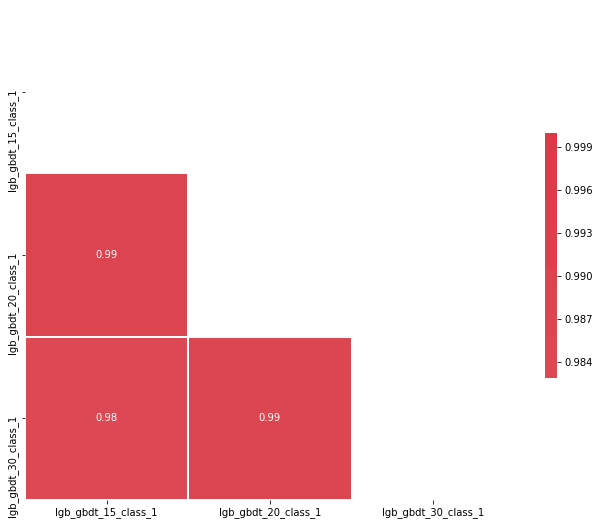

In [264]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = df_btrain_lgb.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0.8, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

# II. All models

In [330]:
df_btrain = df_btrain.merge(df_btrain_rf, how='left', on='Index test')
df_btrain = df_btrain.merge(df_btrain_lgb, how='left', on='Index test')

In [331]:
df_btest = df_btest.merge(df_btest_rf, how='left', on='Unique_ID')
df_btest = df_btest.merge(df_btest_lgb, how='left', on='Unique_ID')

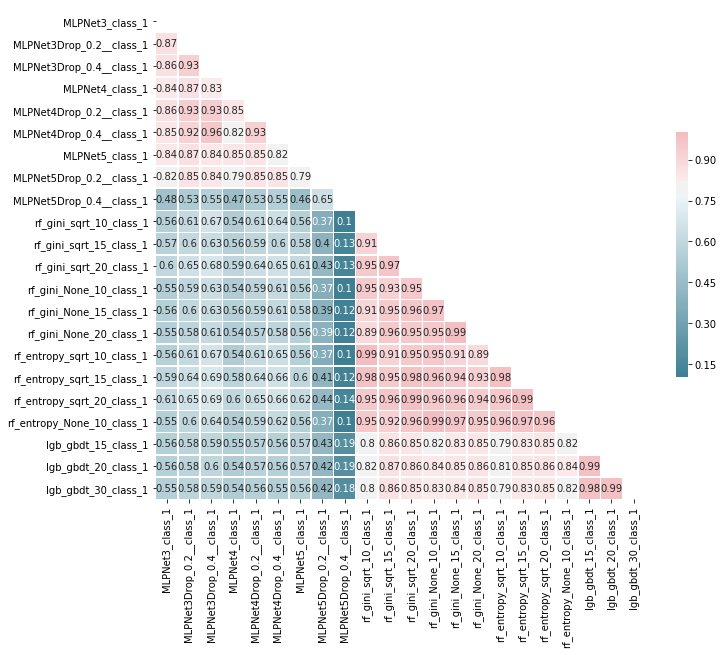

In [325]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = df_btrain.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0.8, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

In [271]:
bttrain, bttest, y_bttrain, y_bttest = train_test_split(df_btrain.iloc[:, 1:], y_train, stratify=y_train,
                                                        random_state=random_state, test_size=0.1)

## II.Mean proba

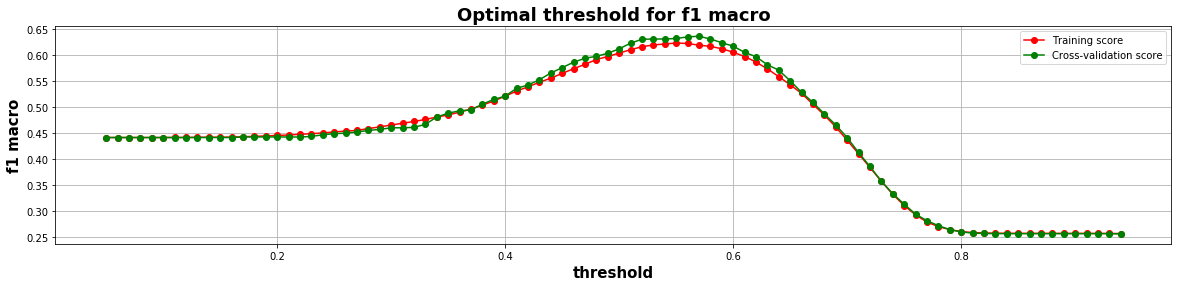

CPU times: user 855 ms, sys: 17 ms, total: 872 ms
Wall time: 885 ms


In [355]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = bttrain.mean(axis=1)
y_prob_val = bttest.mean(axis=1)

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_bttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_bttest, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

In [356]:
y_pred = np.where(bttrain.mean(axis=1) > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttrain)
print("="*40)
print("Train")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred = np.where(bttest.mean(axis=1) > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttest)
print("="*40)
print("Test")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

Train
Best params {'max_depth': 15, 'n_estimators': 200}
Class 0 | precision 0.3713; recall 0.4964; f1 0.4248 
Class 1 | precision 0.8522; recall 0.7755; f1 0.8121 
Test
Best params {'max_depth': 15, 'n_estimators': 200}
Class 0 | precision 0.3942; recall 0.5249; f1 0.4503 
Class 1 | precision 0.8608; recall 0.7846; f1 0.821 


In [358]:
path_sub = "../submissions/mortgage_3"
path_model = "../trained_models/mortgage_3"
if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)
    
submission_file = pd.read_csv("../data/CAX_MortgageModeling_SubmissionFormat.csv")

df_bpred = pd.DataFrame({'Unique_ID': df_btest['Unique_ID']})
df_bpred.loc[:, 'Result_Predicted'] =  np.where(df_btest.iloc[:, 1:].mean(axis=1) > best_th, 1, 0)
df_bpred.loc[:, 'Result_Predicted']  = df_bpred['Result_Predicted'].map({0: "NOT FUNDED", 1:"FUNDED"})

submission_file = submission_file[['Unique_ID']].merge(df_bpred[['Unique_ID', 'Result_Predicted']], 
                                                       how='left', on=['Unique_ID'])
submission_file.to_csv(os.path.join(path_sub, "metamean_mlp_rf_lgb.csv"), index=False)


# Save the result of the gridsearch
joblib.dump(grid, os.path.join(path_model, 'metamean_mlp_rf_lgb.pkl'))

['../trained_models/mortgage_3/metamean_mlp_rf_lgb.pkl']

## II.2 Logistic regression

In [275]:
%%time
clf = LogisticRegression(solver='liblinear', 
                         fit_intercept=True, 
                         random_state=random_state)

param_grid = {'C':np.logspace(-2, 2, 10), 'penalty':['l1', 'l2']}
grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring=f1_macro_score, 
                    cv=bstrat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

warnings.filterwarnings('ignore')
grid = grid.fit(bttrain, y_bttrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   36.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  5.7min finished


CPU times: user 30.2 s, sys: 508 ms, total: 30.7 s
Wall time: 6min 11s


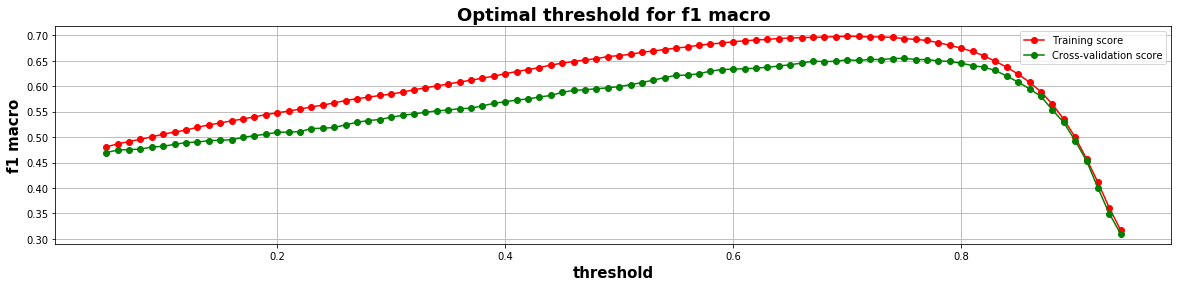

CPU times: user 960 ms, sys: 51 ms, total: 1.01 s
Wall time: 838 ms


In [278]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = grid.best_estimator_.predict_proba(bttrain)[:, 1]
y_prob_val = grid.best_estimator_.predict_proba(bttest)[:, 1]

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_bttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_bttest, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

Train
Best params {'C': 12.915496650148826, 'penalty': 'l1'}
Class 0 | precision 0.4844; recall 0.5831; f1 0.5292 
Class 1 | precision 0.8823; recall 0.8342; f1 0.8576 
Test
Best params {'C': 12.915496650148826, 'penalty': 'l1'}
Class 0 | precision 0.4378; recall 0.4938; f1 0.4641 
Class 1 | precision 0.8601; recall 0.8307; f1 0.8451 


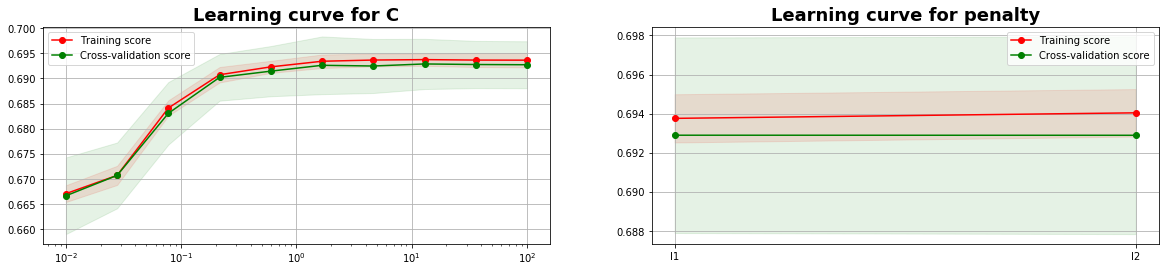

In [344]:
y_pred = np.where(grid.best_estimator_.predict_proba(bttrain)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttrain)
print("="*40)
print("Train")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred = np.where(grid.best_estimator_.predict_proba(bttest)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttest)
print("="*40)
print("Test")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=['C'])

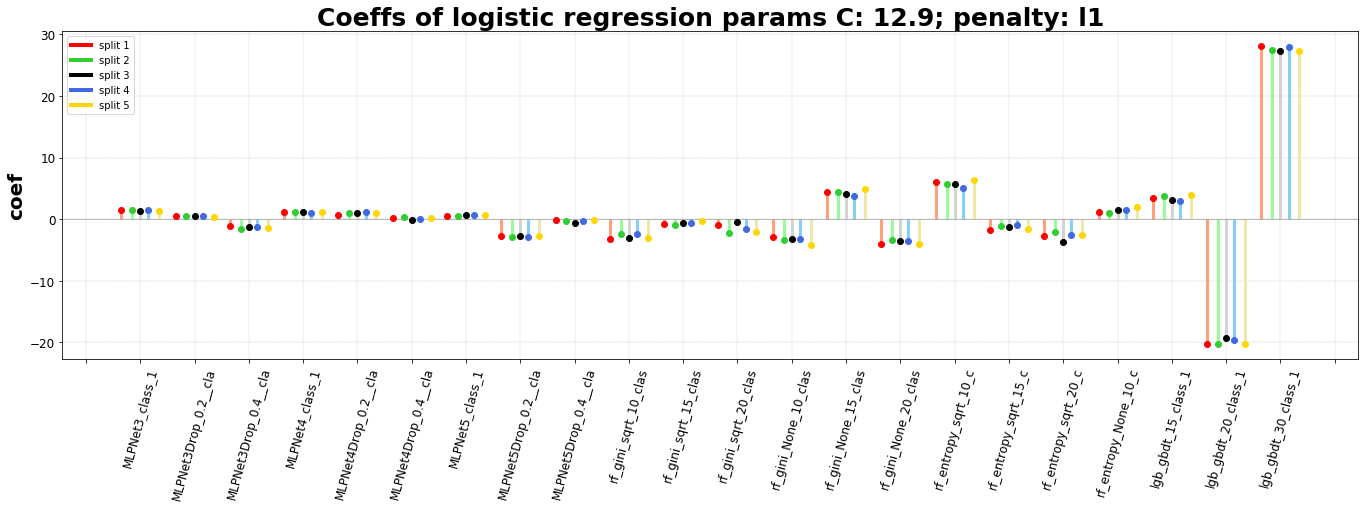

In [282]:
# Compute coefficients on each split with best params
estimator = clone(grid.best_estimator_)
splits = bstrat_cv.split(bttrain, y_bttrain)
list_coeffs = []

for j, (idx_train, idx_test) in enumerate(splits):
    estimator.fit(bttrain.iloc[idx_train], y_bttrain.iloc[idx_train])
    coeffs = pd.DataFrame({'Coef': estimator.coef_.flatten()}, index=bttrain.columns)
    list_coeffs.append(coeffs)

# Plot coefficients 
str_params = []
for k, v in grid.best_params_.items():
    if type(v)==np.int64:
        str_params.append("%s: %d" % (str(k), v))
    elif type(v)==np.float64:
        str_params.append("%s: %.3g" % (str(k), v))
    else:
        str_params.append("%s: %s" % (str(k), str(v)))

title = "logistic regression params %s" % ('; '.join(str_params))

n_coeffs = list_coeffs[0].shape[0]
n_coeffs_fig = 30
n_fig = np.int(np.ceil(n_coeffs/n_coeffs_fig))
for j in range(n_fig):
    sublist_coeffs = [coeffs.iloc[n_coeffs_fig*j:n_coeffs_fig*(j+1)] for coeffs in list_coeffs]
    plot_compare_coeffs(sublist_coeffs, title)

In [347]:
df_btest.head(10)

,Unique_ID,MLPNet3_class_1,MLPNet3Drop_0.2__class_1,MLPNet3Drop_0.4__class_1,MLPNet4_class_1,MLPNet4Drop_0.2__class_1,MLPNet4Drop_0.4__class_1,MLPNet5_class_1,MLPNet5Drop_0.2__class_1,MLPNet5Drop_0.4__class_1,...,rf_gini_None_10_class_1,rf_gini_None_15_class_1,rf_gini_None_20_class_1,rf_entropy_sqrt_10_class_1,rf_entropy_sqrt_15_class_1,rf_entropy_sqrt_20_class_1,rf_entropy_None_10_class_1,lgb_gbdt_15_class_1,lgb_gbdt_20_class_1,lgb_gbdt_30_class_1
0,CAX_Test_1,0.844630,0.753742,0.709095,0.811107,0.844400,0.697407,0.795998,0.763917,0.527535,...,0.469374,0.496955,0.467501,0.480284,0.509724,0.530357,0.511802,0.702632,0.683693,0.679961
1,CAX_Test_2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.785524,0.527535,...,1.000000,1.000000,1.000000,0.955052,0.983852,0.992422,1.000000,0.998822,0.997960,0.998225
2,CAX_Test_3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.785524,0.527535,...,1.000000,1.000000,1.000000,0.971496,0.997352,0.998995,1.000000,0.998965,0.998380,0.998376
3,CAX_Test_4,0.470673,0.386756,0.286437,0.375071,0.253094,0.337551,0.183476,0.247081,0.397876,...,0.605336,0.666838,0.693029,0.557031,0.593649,0.647289,0.603530,0.853866,0.841542,0.860605
4,CAX_Test_5,0.748717,0.686144,0.663214,0.689501,0.687333,0.659122,0.491329,0.662016,0.527535,...,0.608398,0.660966,0.717096,0.572349,0.602945,0.644469,0.622992,0.857855,0.856609,0.862812
5,CAX_Test_6,0.765187,0.663519,0.629889,0.721754,0.705102,0.683279,0.736032,0.761755,0.527535,...,0.378388,0.438845,0.448873,0.396758,0.445420,0.464873,0.391173,0.534380,0.591194,0.583821
6,CAX_Test_7,0.656907,0.466851,0.598759,0.483998,0.717895,0.637591,0.736032,0.698874,0.527535,...,0.361453,0.390204,0.402112,0.425136,0.417766,0.450598,0.366154,0.656603,0.678406,0.676241
7,CAX_Test_8,0.871960,0.917211,0.848031,0.864279,0.844105,0.827091,0.894874,0.785524,0.527535,...,0.611570,0.730647,0.771757,0.520389,0.595415,0.655933,0.606711,0.857874,0.841188,0.838979
8,CAX_Test_9,0.435595,0.646778,0.630637,0.695857,0.573297,0.643413,0.736032,0.583071,0.527535,...,0.505192,0.585365,0.611506,0.521869,0.559818,0.621159,0.501973,0.834484,0.817749,0.833885
9,CAX_Test_10,0.843711,0.800766,0.729290,0.930613,0.744167,0.702150,0.895301,0.785524,0.527535,...,0.646530,0.720879,0.801314,0.603716,0.652219,0.705555,0.636245,0.895100,0.887075,0.889390


### Make prediction and dump the model

In [343]:
path_sub = "../submissions/mortgage_3"
path_model = "../trained_models/mortgage_3"
if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)
    
submission_file = pd.read_csv("../data/CAX_MortgageModeling_SubmissionFormat.csv")

df_bpred = pd.DataFrame({'Unique_ID': df_btest['Unique_ID']})
df_bpred.loc[:, 'Result_Predicted'] =  np.where(grid.best_estimator_.predict_proba(df_btest.iloc[:, 1:])[:, 1] > best_th, 1, 0)
df_bpred.loc[:, 'Result_Predicted']  = df_bpred['Result_Predicted'].map({0: "NOT FUNDED", 1:"FUNDED"})

submission_file = submission_file[['Unique_ID']].merge(df_bpred[['Unique_ID', 'Result_Predicted']], 
                                                       how='left', on=['Unique_ID'])
submission_file.to_csv(os.path.join(path_sub, "metalogreg_mlp_rf_lgb.csv"), index=False)


# Save the result of the gridsearch
joblib.dump(grid, os.path.join(path_model, 'metalogreg_mlp_rf_lgb.pkl'))

['../trained_models/mortgage_3/metalogreg_mlp_rf_lgb.pkl']

## II. 3RandomForest

In [348]:
%%time
clf = RandomForestClassifier(criterion='gini',
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_leaf_nodes=None,
                             bootstrap=True,
                             random_state=random_state,
                             class_weight="balanced")

param_grid = {'n_estimators': [20, 40, 100, 200], 
              'max_depth': [5, 10, 15]}

grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='f1_macro', 
                    cv=bstrat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

warnings.filterwarnings('ignore')
grid = grid.fit(bttrain, y_bttrain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:  3.4min finished


CPU times: user 24.7 s, sys: 543 ms, total: 25.2 s
Wall time: 3min 50s


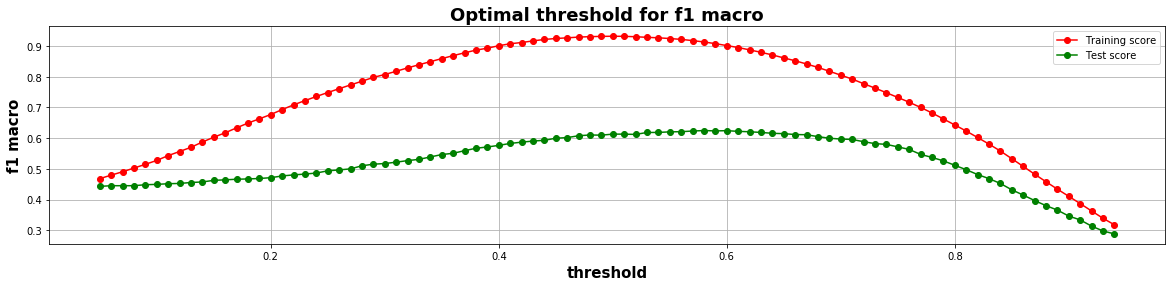

CPU times: user 2.12 s, sys: 29.5 ms, total: 2.15 s
Wall time: 2.17 s


In [354]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = grid.best_estimator_.predict_proba(bttrain)[:, 1]
y_prob_test = grid.best_estimator_.predict_proba(bttest)[:, 1]

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_test = []
best_th = 0
best_f1_test = 0

for th in thresh:
    f1_train = f1_score(y_bttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_test = f1_score(y_bttest, np.where(y_prob_test > th, 1, 0), average='macro')
    if f1_test > best_f1_test:
        best_f1_test = f1_test
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_test.append(f1_test)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_test, 'o-', color="g", label="Test score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

Train
Best params {'max_depth': 15, 'n_estimators': 200}
Class 0 | precision 0.7785; recall 0.9802; f1 0.8678 
Class 1 | precision 0.9943; recall 0.9255; f1 0.9587 
Test
Best params {'max_depth': 15, 'n_estimators': 200}
Class 0 | precision 0.4026; recall 0.421; f1 0.4116 
Class 1 | precision 0.8435; recall 0.8332; f1 0.8383 


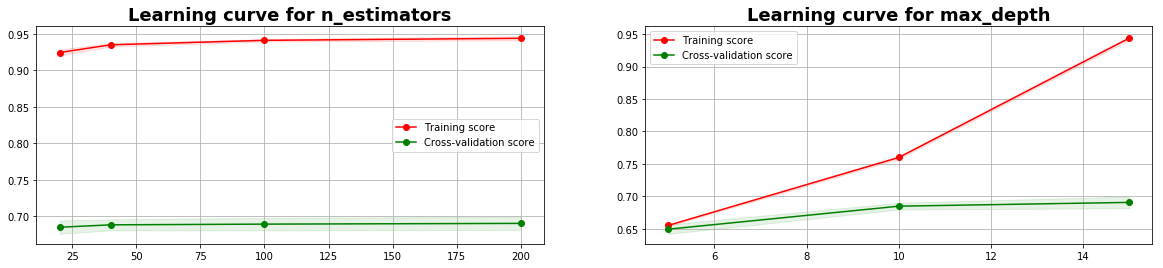

In [350]:
y_pred = np.where(grid.best_estimator_.predict_proba(bttrain)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttrain)
print("="*40)
print("Train")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred = np.where(grid.best_estimator_.predict_proba(bttest)[:, 1] > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttest)
print("="*40)
print("Test")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=['C'])

## II.4 LGBM

In [369]:
lgb_train = lgb.Dataset(bttrain, y_bttrain, feature_name='auto', free_raw_data=False)
lgb_test = lgb.Dataset(bttest, y_bttest, feature_name='auto', free_raw_data=False)

params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'binary_logloss',
          'num_leaves': 25,
          'learning_rate': 0.05,
          'feature_fraction': 0.7,
          'bagging_fraction': 0.9,
          'bagging_freq': 5,
          'num_boost_round': 400,
          'early_stopping_rounds': 25,
          'verbose': 0}

gbm = lgb.train(params,
                lgb_train,
                feval=f1_macro_eval,
                valid_sets=[lgb_test],               
                valid_names=['test'],
                verbose_eval=False)

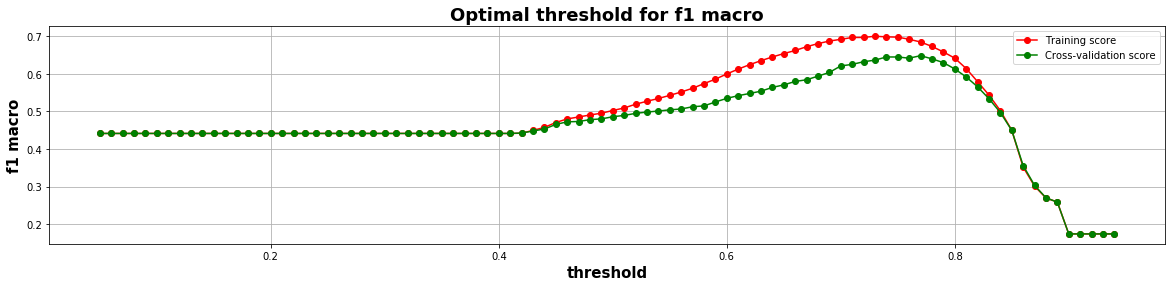

CPU times: user 1.39 s, sys: 146 ms, total: 1.53 s
Wall time: 848 ms


In [372]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = gbm.predict(bttrain)
y_prob_val = gbm.predict(bttest)

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_bttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_bttest, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

In [374]:
y_pred = np.where(gbm.predict(bttrain) > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttrain)
print("="*40)
print("Train")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred = np.where(gbm.predict(bttest) > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred, y_bttest)
print("="*40)
print("Test")
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

Train
Best params {}
Class 0 | precision 0.4513; recall 0.6393; f1 0.5291 
Class 1 | precision 0.8916; recall 0.7925; f1 0.8391 
Test
Best params {}
Class 0 | precision 0.4105; recall 0.5457; f1 0.4685 
Class 1 | precision 0.867; recall 0.7907; f1 0.8271 


### Make prediction and dump the model

In [377]:
path_sub = "../submissions/mortgage_3"
path_model = "../trained_models/mortgage_3"
if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)
    
submission_file = pd.read_csv("../data/CAX_MortgageModeling_SubmissionFormat.csv")

df_bpred = pd.DataFrame({'Unique_ID': df_btest['Unique_ID']})
df_bpred.loc[:, 'Result_Predicted'] =  np.where(gbm.predict(df_btest.iloc[:, 1:]) > best_th, 1, 0)
df_bpred.loc[:, 'Result_Predicted']  = df_bpred['Result_Predicted'].map({0: "NOT FUNDED", 1:"FUNDED"})

submission_file = submission_file[['Unique_ID']].merge(df_bpred[['Unique_ID', 'Result_Predicted']], 
                                                       how='left', on=['Unique_ID'])
submission_file.to_csv(os.path.join(path_sub, "metagbm_mlp_rf_lgb.csv"), index=False)


# Save the result of the gridsearch
joblib.dump(grid, os.path.join(path_model, 'metagbm_mlp_rf_lgb.pkl'))

['../trained_models/mortgage_3/metagbm_mlp_rf_lgb.pkl']